In [10]:
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import os
from platform import python_version
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime
import seaborn as sns
from linearmodels.panel import PooledOLS
import statsmodels.api as sm

In [11]:
data = pd.read_csv("/Users/xiaohuili/Xiaohui/Career/MBA/Course/ELP_World Bank/Python Code/firm_view.csv")
geofin_info = pd.read_csv("/Users/xiaohuili/Xiaohui/Career/MBA/Course/ELP_World Bank/Python Code/geographic_financial_entity_info.csv")

In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262696 entries, 0 to 262695
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          262696 non-null  int64  
 1   firm_id             262696 non-null  object 
 2   firm_name           262696 non-null  object 
 3   firm_country        262696 non-null  object 
 4   firm_region         262696 non-null  object 
 5   firm_isin           262696 non-null  object 
 6   firm_sector         262365 non-null  object 
 7   firm_ind_grp        262365 non-null  object 
 8   firm_ind            262365 non-null  object 
 9   firm_WACC           262696 non-null  float64
 10  firm_EVA            262696 non-null  float64
 11  firm_ROIC           262696 non-null  float64
 12  firm_market cap     262696 non-null  float64
 13  firm_asset          262684 non-null  float64
 14  firm_revenue        262293 non-null  float64
 15  firm_profit         262583 non-nul

In [158]:
data['partner_EVAspread'].quantile(0.98)

21.801001072

In [159]:
# Disgard top 1% and bottom 1% companies by EVA spread
overview = data[(data['firm_EVAspread']> -66.1) &(data['firm_EVAspread']< 21.8)&
          (data['partner_EVAspread']< 21.8) & (data['partner_EVAspread']> -66.1)]

In [160]:
overview.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241468 entries, 0 to 262694
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          241468 non-null  int64  
 1   firm_id             241468 non-null  object 
 2   firm_name           241468 non-null  object 
 3   firm_country        241468 non-null  object 
 4   firm_region         241468 non-null  object 
 5   firm_isin           241468 non-null  object 
 6   firm_sector         241214 non-null  object 
 7   firm_ind_grp        241214 non-null  object 
 8   firm_ind            241214 non-null  object 
 9   firm_WACC           241468 non-null  float64
 10  firm_EVA            241468 non-null  float64
 11  firm_ROIC           241468 non-null  float64
 12  firm_market cap     241468 non-null  float64
 13  firm_asset          241456 non-null  float64
 14  firm_revenue        241079 non-null  float64
 15  firm_profit         241361 non-nul

In [161]:
# Calculate averge finance pivot table -- all customers and suppliers
pivot = overview.pivot_table(values=['firm_EVAspread','firm_EVA','firm_class','partner_EVAspread','partner_EVA',
                                     'partner_class','relation_duration'], index = 'firm_id')
pivot = pivot.reset_index()
pivot

,firm_id,firm_EVA,firm_EVAspread,firm_class,partner_EVA,partner_EVAspread,partner_class,relation_duration
0,000BDW-E,-4.395214e+06,-1.964000,6,1.785284e+08,10.904999,9.000000,8.542270
1,000BDX-E,1.378898e+07,0.970000,8,-6.700830e+07,-2.732000,4.000000,3.909731
2,000BFS-E,-6.890866e+07,-5.515000,4,-1.212172e+08,-0.490431,5.588235,29.664739
3,000BFT-E,-5.521327e+08,-20.120000,2,-5.190711e+08,-8.762583,4.541667,19.711561
4,000BG2-E,2.452297e+08,0.491000,9,-9.173424e+05,-1.372314,6.390476,23.845449
...,...,...,...,...,...,...,...,...
18631,0M2CT8-E,3.066073e+06,0.214000,7,2.392557e+08,7.557667,9.000000,3.712602
18632,0M2NBB-E,7.641380e+07,0.802000,8,-1.935033e+08,-1.327583,4.666667,3.876876
18633,0M2SYP-E,-8.882539e+08,-6.480000,2,-1.256619e+08,-4.685588,5.294118,3.440100
18634,0M3M1N-E,-1.069754e+07,-39.478999,6,1.044895e+10,9.427375,9.000000,3.449763


In [162]:
# EVA total relationship, no record loss -- all companies
company_pivot = pd.merge(pivot,geofin_info,left_on = 'firm_id',right_on ='factset_entity_id',how = 'inner')
company_pivot = company_pivot.sort_values(['firm_EVA'])
company_pivot1= company_pivot[[
    'factset_entity_id','entity_proper_name', 'iso_country','region','entity_type','GICS Ind Grp Name',
    'firm_EVA','firm_EVAspread','firm_class','partner_EVA','partner_EVAspread','partner_class','relation_duration'
                ]]
dt = company_pivot1.rename(columns={
    'factset_entity_id':'firm_id', 'entity_proper_name':'firm_name', 'iso_country':'firm_country',
    'region':'firm_region','GICS Ind Grp Name':'firm_industry'})

dt.info()
dt.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18636 entries, 595 to 9494
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   firm_id            18636 non-null  object 
 1   firm_name          18636 non-null  object 
 2   firm_country       18636 non-null  object 
 3   firm_region        18636 non-null  object 
 4   entity_type        18636 non-null  object 
 5   firm_industry      18552 non-null  object 
 6   firm_EVA           18636 non-null  float64
 7   firm_EVAspread     18636 non-null  float64
 8   firm_class         18636 non-null  int64  
 9   partner_EVA        18636 non-null  float64
 10  partner_EVAspread  18636 non-null  float64
 11  partner_class      18636 non-null  float64
 12  relation_duration  18636 non-null  float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.0+ MB


,firm_id,firm_name,firm_country,firm_region,entity_type,firm_industry,firm_EVA,firm_EVAspread,firm_class,partner_EVA,partner_EVAspread,partner_class,relation_duration
595,000TWC-E,Prudential Plc,GB,ECA,PUB,Insurance,-2.100000e+11,-49.975000,1,-6.983822e+08,-1.933636,6.527273,17.296006
1294,001VPR-E,AXA SA,FR,ECA,PUB,Insurance,-2.020000e+11,-27.664999,1,1.817281e+09,-3.949000,5.875000,22.109420
15729,0BT2BZ-E,Swiss Re AG,CH,ECA,PUB,Insurance,-5.034630e+10,-32.737999,1,-1.915949e+09,-2.200132,5.552632,45.452138
14077,081DD5-E,"JAPAN POST INSURANCE Co., Ltd.",JP,EAP,PUB,Insurance,-3.918935e+10,-6.020000,1,-4.634060e+08,-3.951000,2.500000,19.187252
4188,05HWBM-E,Gazprom PJSC,RU,ECA,PUB,Energy,-3.139980e+10,-10.948000,1,-1.286505e+09,-5.008512,4.658537,22.678284
1435,0029XB-E,SoftBank Group Corp.,JP,EAP,PUB,Telecommunication Services,-2.831645e+10,-13.534000,1,-1.473572e+08,-6.784984,5.483607,20.883318
265,000JHG-E,Federal National Mortgage Association,US,NOAM,PUB,Banks,-2.441127e+10,-0.680000,1,9.651852e+08,-4.076696,6.434783,42.565645
979,0015N4-E,Schlumberger NV,US,NOAM,PUB,Energy,-1.967529e+10,-55.399001,1,-6.347351e+08,-7.271867,5.228571,22.353212
144,000DP6-E,Chevron Corp.,US,NOAM,PUB,Energy,-1.815244e+10,-9.731000,1,-4.046910e+08,-7.695862,5.099678,25.450281
1506,002J79-E,Legal & General Group Plc,GB,ECA,PUB,Insurance,-1.769622e+10,-3.380000,1,-9.826247e+07,-1.516077,5.538462,19.475364


In [164]:
# Filter ECA, Turkey and Germany Companies
ECA = dt[(dt['firm_region']=='ECA')]
turkey = dt[(dt['firm_country']=='TR')]
germany = dt[(dt['firm_country']=='DE')] 
us = dt[(dt['firm_country']=='IN')] 
china = dt[(dt['firm_country']=='CN')] 

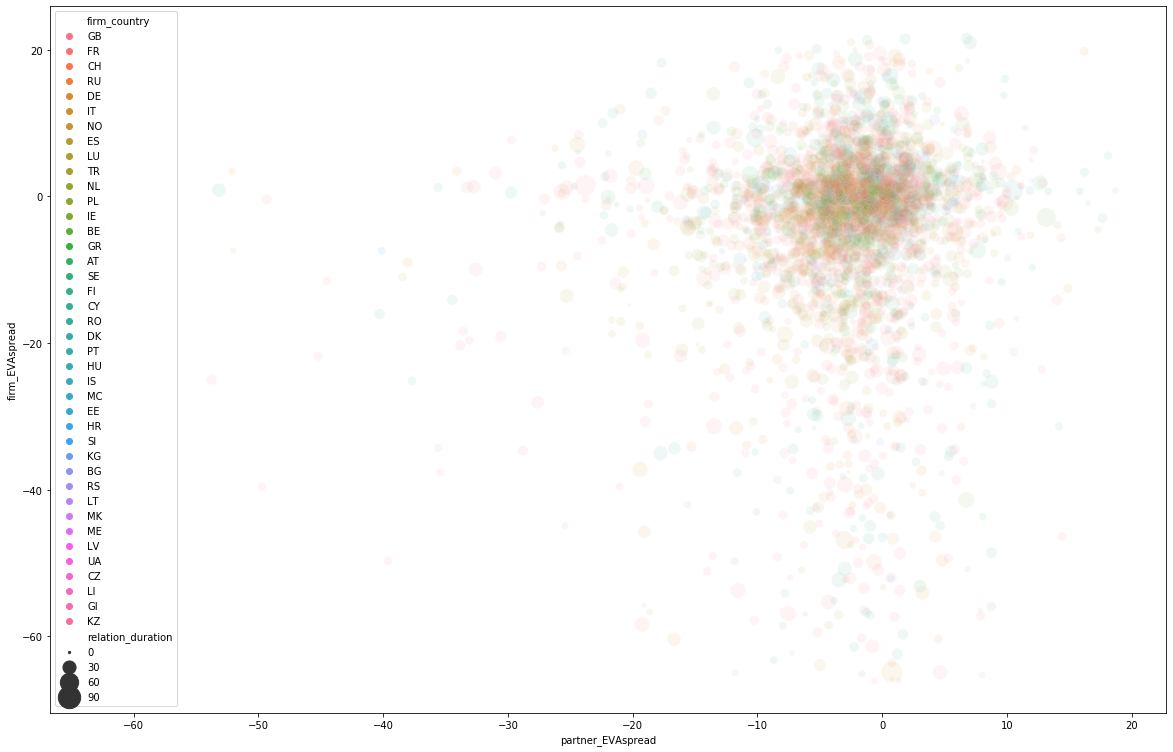

In [81]:
# Data visulization_ECA
plt.figure(figsize=(20,13))
plot_ECA = sns.scatterplot(data=ECA, x='partner_EVAspread', y='firm_EVAspread', alpha=0.08, hue='firm_country', size='relation_duration',
                      sizes=(5, 500))

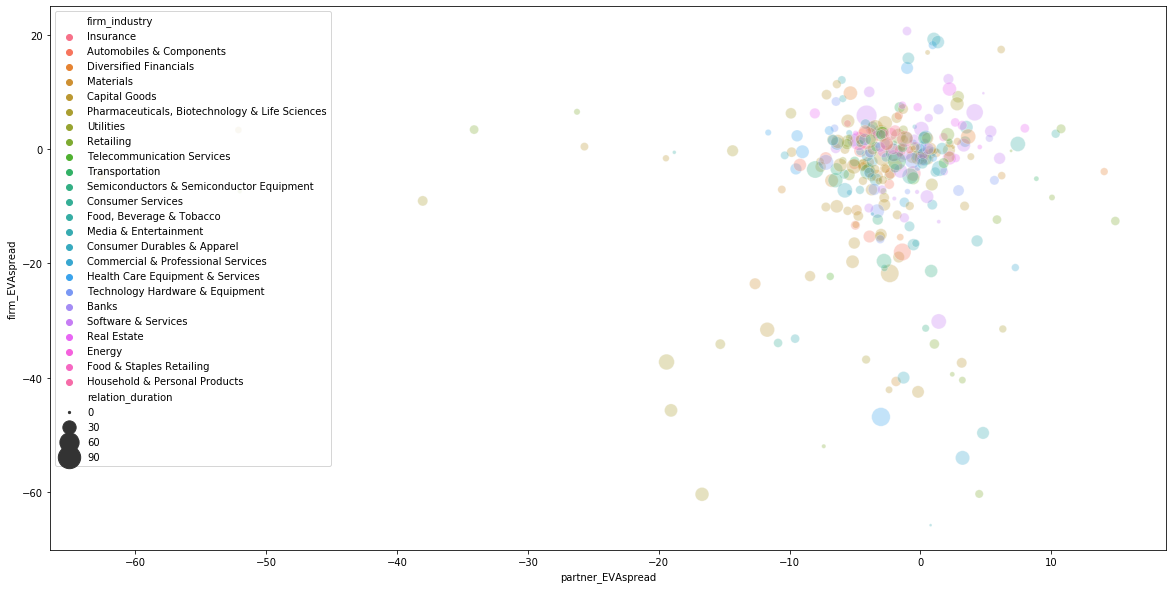

In [109]:
# Data visulization_Germany
plt.figure(figsize=(20,10))
plot_germany = sns.scatterplot(data=germany, x='partner_EVAspread', y='firm_EVAspread', alpha=0.3, hue='firm_industry', size='relation_duration',
                      sizes=(5, 500))

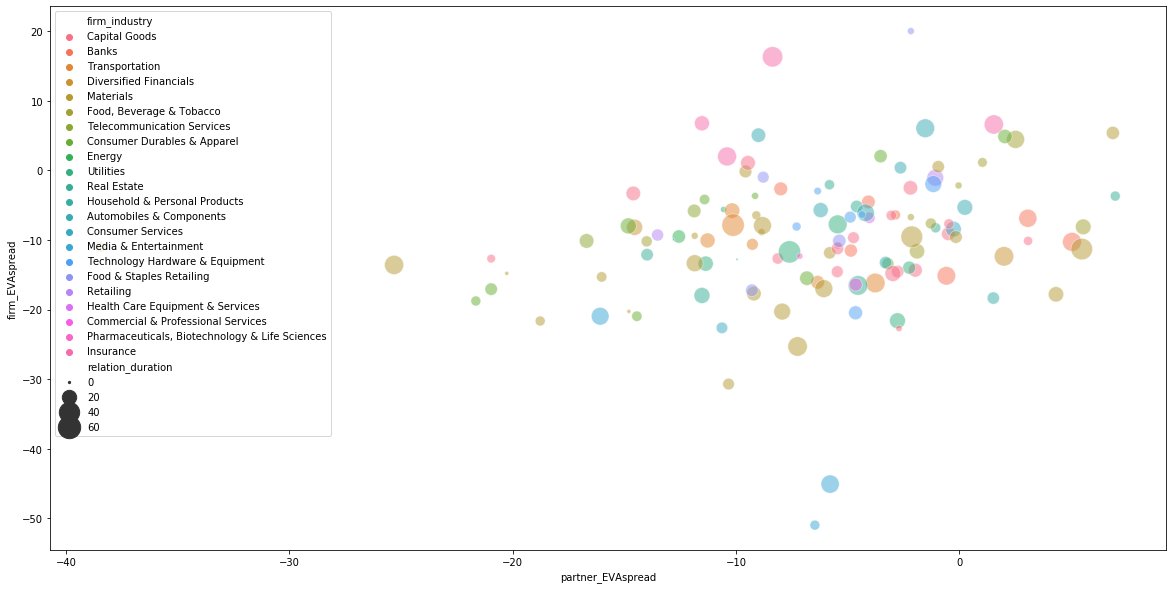

In [83]:
# Data visulization_Turkey
plt.figure(figsize=(20,10))
plot_turkey = sns.scatterplot(data=turkey, x='partner_EVAspread', y='firm_EVAspread', alpha=0.5, hue='firm_industry', size='relation_duration',
                      sizes=(5, 500))

In [70]:
# ols on ECA. Combined customer & suppliers
# use firm & partner's EVAspread, high significance on partner_EVAspread and relation duration, positive coefficient, low R2
res_ECA = sm.OLS(ECA['firm_EVAspread'], ECA[['partner_EVAspread','relation_duration']]).fit()
result_ECA = sm.OLS(ECA['firm_EVAspread'], sm.add_constant(ECA[['partner_EVAspread','relation_duration']])).fit()
result_ECA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         firm_EVAspread   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     13.67
Date:                Thu, 20 Aug 2020   Prob (F-statistic):           1.23e-06
Time:                        15:27:21   Log-Likelihood:                -12938.
No. Observations:                3252   AIC:                         2.588e+04
Df Residuals:                    3249   BIC:                         2.590e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.2508      0.483    -10.864      0.000      -6.198      -4.303
partner_EVAspread     0.1373      0.033      4.155      0.000       0.073       0.202
relation_duration     0.0664      0.021      3.167      0.002       0.025       0.107
==============================================================================
Omnibus:                     1317.369   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5714.496
Skew:                          -1.961   Prob(JB):                         0.00
Kurtosis:                       8.176   Cond. No.                         48.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
# ols on Germany: Combined customer & suppliers
# use firm & partner's EVAspread, no significance on partner_EVAspread and relation duration, very low R2
res_DE = sm.OLS(germany['firm_EVAspread'], germany[['partner_EVAspread','relation_duration']]).fit()
result_DE = sm.OLS(germany['firm_EVAspread'], sm.add_constant(germany[['partner_EVAspread','relation_duration']])).fit()
result_DE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         firm_EVAspread   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2905
Date:                Thu, 20 Aug 2020   Prob (F-statistic):              0.748
Time:                        15:58:27   Log-Likelihood:                -1262.3
No. Observations:                 315   AIC:                             2531.
Df Residuals:                     312   BIC:                             2542.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.7046      1.634     -2.880      0.004      -7.919      -1.490
partner_EVAspread     0.0738      0.097      0.760      0.448      -0.117       0.265
relation_duration     0.0033      0.067      0.049      0.961      -0.129       0.136
==============================================================================
Omnibus:                      137.774   Durbin-Watson:                   1.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              488.087
Skew:                          -1.958   Prob(JB):                    1.03e-106
Kurtosis:                       7.675   Cond. No.                         52.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
# ols on Turkey: Combined customer & suppliers
# use firm & partner's EVAspread, 1% significance on EVAspread, positive coefficient, no significance relation duration, high R2
res_TR = sm.OLS(turkey['firm_EVAspread'], turkey[['partner_EVAspread','relation_duration']]).fit()
result_TR = sm.OLS(turkey['firm_EVAspread'], sm.add_constant(turkey[['partner_EVAspread','relation_duration']])).fit()
result_TR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         firm_EVAspread   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.901
Date:                Thu, 20 Aug 2020   Prob (F-statistic):             0.0588
Time:                        15:31:02   Log-Likelihood:                -450.00
No. Observations:                 124   AIC:                             906.0
Df Residuals:                     121   BIC:                             914.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.6144      1.965     -3.875      0.000     -11.505      -3.724
partner_EVAspread     0.2924      0.122      2.390      0.018       0.050       0.535
relation_duration    -0.0099      0.079     -0.126      0.900      -0.166       0.146
==============================================================================
Omnibus:                       30.718   Durbin-Watson:                   1.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.917
Skew:                          -0.751   Prob(JB):                     5.54e-27
Kurtosis:                       7.599   Cond. No.                         52.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

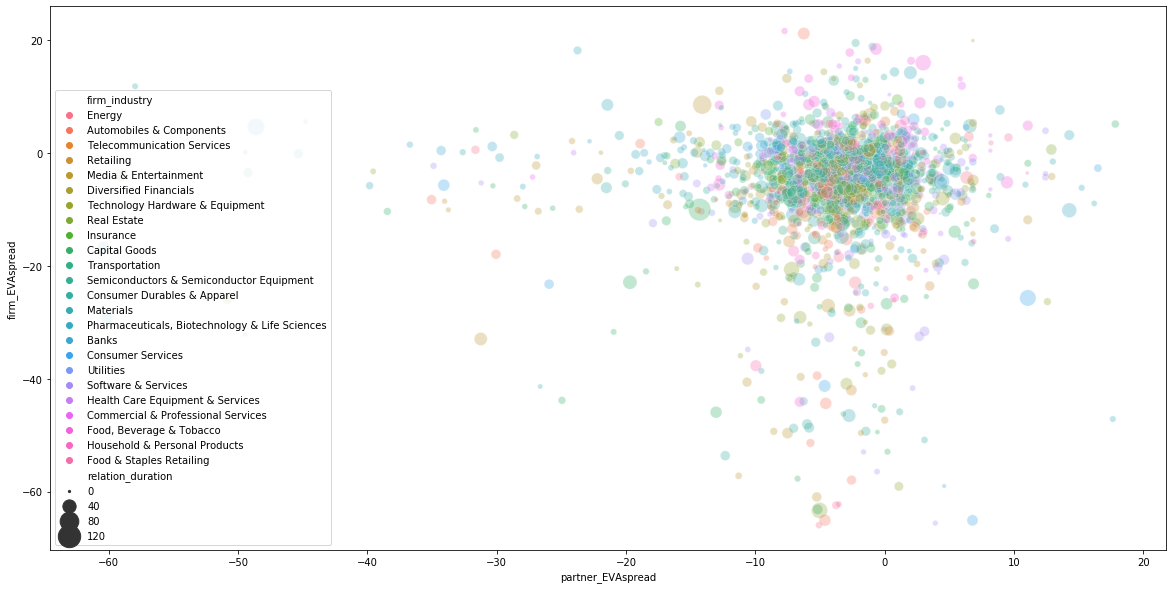

In [84]:
plt.figure(figsize=(20,10))
plot_china = sns.scatterplot(data=china, x='partner_EVAspread', y='firm_EVAspread', alpha=0.3, hue='firm_industry', size='relation_duration',
                      sizes=(5, 500))

In [76]:
# ols on Turkey: Combined customer & suppliers
# use firm & partner's EVAspread, 1% significance on EVAspread, positive coefficient, no significance relation duration, high R2
res_CN = sm.OLS(china['firm_EVAspread'], china[['partner_EVAspread','relation_duration']]).fit()
result_CN = sm.OLS(china['firm_EVAspread'], sm.add_constant(china[['partner_EVAspread','relation_duration']])).fit()
result_CN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         firm_EVAspread   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.018
Date:                Thu, 20 Aug 2020   Prob (F-statistic):              0.362
Time:                        15:35:25   Log-Likelihood:                -7740.0
No. Observations:                2069   AIC:                         1.549e+04
Df Residuals:                    2066   BIC:                         1.550e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.1856      0.429    -12.096      0.000      -6.026      -4.345
partner_EVAspread     0.0327      0.032      1.032      0.302      -0.029       0.095
relation_duration    -0.0198      0.020     -0.970      0.332      -0.060       0.020
==============================================================================
Omnibus:                     1134.788   Durbin-Watson:                   1.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9999.280
Skew:                          -2.457   Prob(JB):                         0.00
Kurtosis:                      12.584   Cond. No.                         39.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

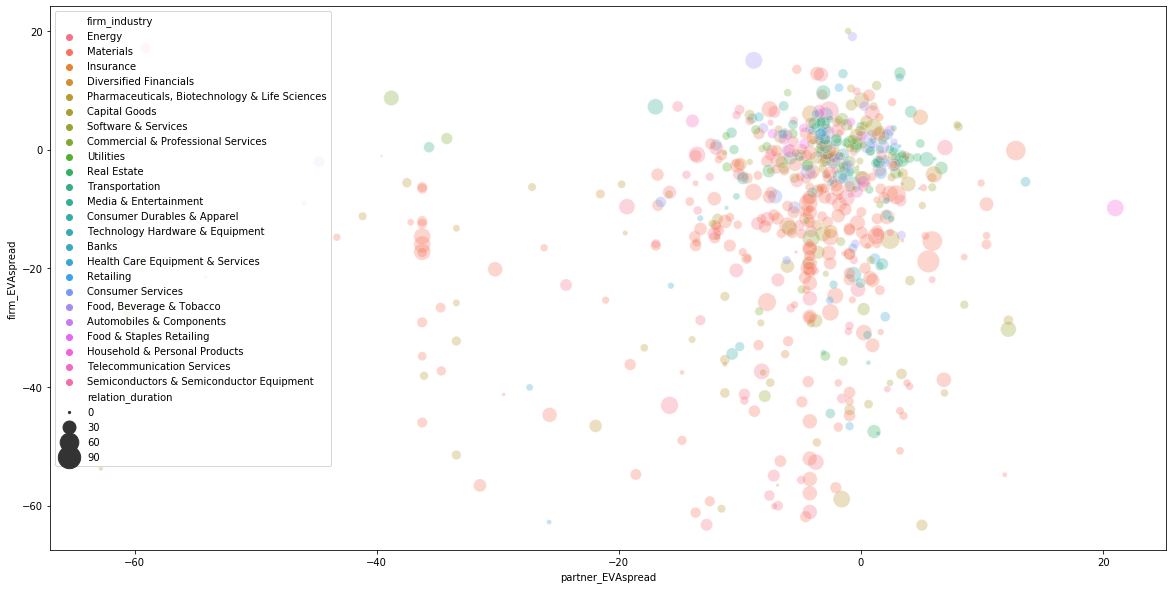

In [102]:
plt.figure(figsize=(20,10))
plot_us = sns.scatterplot(data=us, x='partner_EVAspread', y='firm_EVAspread', alpha=0.3, hue='firm_industry', size='relation_duration',
                      sizes=(5, 500))

In [103]:
# ols on Turkey: Combined customer & suppliers
# use firm & partner's EVAspread, 1% significance on EVAspread, positive coefficient, no significance relation duration, high R2
res_US = sm.OLS(us['firm_EVAspread'], us[['partner_EVAspread','relation_duration']]).fit()
result_US = sm.OLS(us['firm_EVAspread'], sm.add_constant(us[['partner_EVAspread','relation_duration']])).fit()
result_US.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         firm_EVAspread   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     9.879
Date:                Thu, 20 Aug 2020   Prob (F-statistic):           5.96e-05
Time:                        15:54:20   Log-Likelihood:                -2678.0
No. Observations:                 633   AIC:                             5362.
Df Residuals:                     630   BIC:                             5375.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -10.4043      1.489     -6.987      0.000     -13.328      -7.480
partner_EVAspread     0.2545      0.057      4.427      0.000       0.142       0.367
relation_duration    -0.0026      0.055     -0.047      0.962      -0.112       0.106
==============================================================================
Omnibus:                       98.854   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.524
Skew:                          -1.103   Prob(JB):                     6.83e-32
Kurtosis:                       3.756   Cond. No.                         58.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1]:
"""
Inspired by Stata's binscatter, described fully by Michael Stepner at
https://michaelstepner.com/binscatter/.
"""
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn import linear_model
from scipy import sparse as sps


def get_binscatter_objects(y, x, controls, n_bins, recenter_x, recenter_y, bins):
    """
    Returns mean x and mean y within each bin, and coefficients if residualizing.
    Parameters are essentially the same as in binscatter.
    """
    # Check if data is sorted

    if controls is None:
        if np.any(np.diff(x) < 0):
            argsort = np.argsort(x)
            x = x[argsort]
            y = y[argsort]
        x_data = x
        y_data = y
    else:
        # Residualize
        if controls.ndim == 1:
            controls = controls[:, None]

        demeaning_y_reg = linear_model.LinearRegression().fit(controls, y)
        y_data = y - demeaning_y_reg.predict(controls)

        demeaning_x_reg = linear_model.LinearRegression().fit(controls, x)
        x_data = x - demeaning_x_reg.predict(controls)
        argsort = np.argsort(x_data)
        x_data = x_data[argsort]
        y_data = y_data[argsort]

        if recenter_y:
            y_data += np.mean(y)
        if recenter_x:
            x_data += np.mean(x)

    if x_data.ndim == 1:
        x_data = x_data[:, None]
    reg = linear_model.LinearRegression().fit(x_data, y_data)
    if bins is None:
        bin_edges = np.linspace(0, len(y), n_bins + 1).astype(int)
        assert len(bin_edges) == n_bins + 1
        bins = [slice(bin_edges[i], bin_edges[i + 1]) for i in range(len(bin_edges) - 1)]
        assert len(bins) == n_bins

    x_means = [np.mean(x_data[bin_]) for bin_ in bins]
    y_means = [np.mean(y_data[bin_]) for bin_ in bins]

    return x_means, y_means, reg.intercept_, reg.coef_[0]


def binscatter(self, x, y, controls=None, n_bins=20,
               line_kwargs=None, scatter_kwargs=None, recenter_x=False,
               recenter_y=True, bins=None):
    """
    :param self: matplotlib.axes.Axes object.
        i.e., fig, axes = plt.subplots(3)
              axes[0].binscatter(x, y)
    :param y: 1d numpy array or pandas series
    :param x: 1d numpy array or Pandas Series
    :param controls: numpy array or sparse matrix
    :param n_bins: int, default 20
    :param line_kwargs: keyword arguments passed to the line in the
    :param scatter_kwargs: dict
    :param recenter_y: If true, recenter y-tilde so its mean is the mean of y
    :param recenter_x: If true, recenter y-tilde so its mean is the mean of y
    :param bins: Indices of each bin. By default, if you leave 'bins' as None,
        binscatter constructs equal sized bins;
        if you don't like that, use this parameter to construct your own.
    :return:
    """
    if line_kwargs is None:
        line_kwargs = {}
    if scatter_kwargs is None:
        scatter_kwargs = {}
    if controls is not None:
        if isinstance(controls, pd.SparseDataFrame) or isinstance(controls, pd.SparseSeries):
            controls = controls.to_coo()
        elif isinstance(controls, pd.DataFrame) or isinstance(controls, pd.Series):
            controls = controls.values
        assert isinstance(controls, np.ndarray) or sps.issparse(controls)

    x_means, y_means, intercept, coef = get_binscatter_objects(np.asarray(y), np.asarray(x),
                                                               controls, n_bins, recenter_x,
                                                               recenter_y, bins)

    self.scatter(x_means, y_means, **scatter_kwargs)
    x_range = np.array(self.get_xlim())
    self.plot(x_range, intercept + x_range * coef, label='beta=' + str(round(coef, 3)), **line_kwargs)
    # If series were passed, might be able to label
    try:
        self.set_xlabel(x.name)
    except AttributeError:
        pass
    try:
        self.set_ylabel(y.name)
    except AttributeError:
        pass
    return x_means, y_means, intercept, coef

matplotlib.axes.Axes.binscatter = binscatter


def main():
    n_obs = 1000
    data = pd.DataFrame({'experience': np.random.poisson(4, n_obs) + 1})
    data['tenure'] = data['experience'] + np.random.normal(0, 1, n_obs)
    data['wage'] = data['experience'] + data['tenure'] + np.random.normal(0, 1, n_obs)

    fig, axes = plt.subplots(1, 2)
    axes[0].binscatter(data['wage'], data['tenure'])
    axes[0].legend()
    axes[0].set_ylabel('Wage')
    axes[0].set_ylabel('Tenure')
    axes[0].set_title('No controls')
    axes[1].binscatter(data['wage'], data['tenure'], controls=data['experience'])
    axes[1].set_xlabel('Tenure (residualized)')
    axes[1].set_ylabel('Wage (residualized, recentered)')
    axes[1].legend()
    axes[1].set_title('Controlling for experience')
    plt.savefig('test')
    plt.close('all')

    # Make y more interpretable
    fig, axes = plt.subplots(1, 2, sharey=True)
    axes[0].binscatter(data['wage'], data['tenure'])
    axes[0].legend()
    axes[0].set_ylabel('Wage')
    axes[0].set_ylabel('Tenure')
    axes[0].set_title('No controls')
    axes[1].binscatter(data['wage'], data['tenure'], controls=data['experience'], recenter_y=True)
    axes[1].set_xlabel('Tenure (residualized, recentered)')
    # axes[1].set_ylabel('Wage (residualized, recentered)')
    axes[1].legend()
    axes[1].set_title('Controlling for experience')
    plt.savefig('test2')
    plt.close('all')
    return

if __name__ == '__main__':
    main()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


In [6]:
from scipy import stats

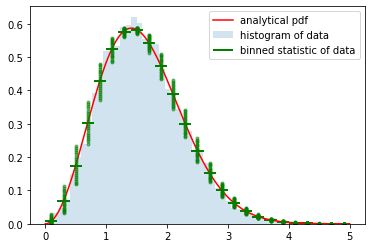

In [39]:
x = np.linspace(0, 5, num=500)
x_pdf = stats.maxwell.pdf(x)
samples = stats.maxwell.rvs(size=10000)

bin_means, bin_edges, binnumber = stats.binned_statistic(x, x_pdf,
        statistic='mean', bins=25)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure()
plt.hist(samples, bins=50, density=True, histtype='stepfilled',
         alpha=0.2, label='histogram of data')
plt.plot(x, x_pdf, 'r-', label='analytical pdf')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,
           label='binned statistic of data')
plt.plot((binnumber - 0.5) * bin_width, x_pdf, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

In [41]:
x

array([0.        , 0.01002004, 0.02004008, 0.03006012, 0.04008016,
       0.0501002 , 0.06012024, 0.07014028, 0.08016032, 0.09018036,
       0.1002004 , 0.11022044, 0.12024048, 0.13026052, 0.14028056,
       0.1503006 , 0.16032064, 0.17034068, 0.18036072, 0.19038076,
       0.2004008 , 0.21042084, 0.22044088, 0.23046092, 0.24048096,
       0.250501  , 0.26052104, 0.27054108, 0.28056112, 0.29058116,
       0.3006012 , 0.31062124, 0.32064128, 0.33066132, 0.34068136,
       0.3507014 , 0.36072144, 0.37074148, 0.38076152, 0.39078156,
       0.4008016 , 0.41082164, 0.42084168, 0.43086172, 0.44088176,
       0.4509018 , 0.46092184, 0.47094188, 0.48096192, 0.49098196,
       0.501002  , 0.51102204, 0.52104208, 0.53106212, 0.54108216,
       0.5511022 , 0.56112224, 0.57114228, 0.58116232, 0.59118236,
       0.6012024 , 0.61122244, 0.62124248, 0.63126253, 0.64128257,
       0.65130261, 0.66132265, 0.67134269, 0.68136273, 0.69138277,
       0.70140281, 0.71142285, 0.72144289, 0.73146293, 0.74148

In [198]:
bin_means, bin_edges, binnumber = stats.binned_statistic(ECA['partner_EVAspread'], ECA['firm_EVAspread'],
        statistic='mean', bins=15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2


In [199]:
binnumber

array([12, 11, 12, ..., 12, 12, 12])

Text(0, 0.5, 'Firm_EVA spread')

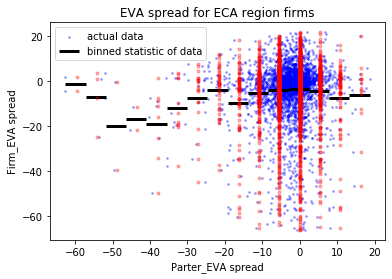

In [205]:
plt.scatter(ECA.partner_EVAspread, ECA.firm_EVAspread, color = 'blue', label='actual data', alpha =0.3, s=3)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='black', lw=3,
           label='binned statistic of data')
plt.plot((binnumber-12)*bin_width, ECA['firm_EVAspread'], 'r.', alpha=0.3, lw=1)
plt.legend(fontsize=10)
plt.title('EVA spread for ECA region firms')
plt.xlabel('Parter_EVA spread')
plt.ylabel('Firm_EVA spread')

In [201]:
firm_ECA=pd.DataFrame()
firm_ECA['firm_EVAspread']=bin_means
firm_ECA['partner_EVAspread'] =bin_centers
firm_ECA

,firm_EVAspread,partner_EVAspread
0,-1.441000,-59.9166
1,-7.037500,-54.4958
2,-20.013000,-49.0750
3,-16.673500,-43.6542
4,-18.938000,-38.2334
5,-11.825909,-32.8126
6,-7.686600,-27.3918
7,-3.922800,-21.9710
8,-9.702740,-16.5502
9,-5.503586,-11.1294


In [202]:
# ols on Turkey: Combined customer & suppliers
# use firm & partner's EVAspread, 1% significance on EVAspread, positive coefficient, no significance relation duration, high R2
res_bineca = sm.OLS(firm_ECA['firm_EVAspread'], firm_ECA[['partner_EVAspread']]).fit()
result_bineca = sm.OLS(firm_ECA['firm_EVAspread'], sm.add_constant(firm_ECA[['partner_EVAspread']])).fit()
result_bineca.summary()

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         firm_EVAspread   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     2.650
Date:                Thu, 20 Aug 2020   Prob (F-statistic):              0.128
Time:                        19:43:31   Log-Likelihood:                -45.703
No. Observations:                  15   AIC:                             95.41
Df Residuals:                      13   BIC:                             96.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.4213      1.937     -3.315      0.006     -10.606      -2.237
partner_EVAspread     0.0982      0.060      1.628      0.128      -0.032       0.228
==============================================================================
Omnibus:                        0.202   Durbin-Watson:                   0.954
Prob(Omnibus):                  0.904   Jarque-Bera (JB):                0.028
Skew:                          -0.019   Prob(JB):                        0.986
Kurtosis:                       2.793   Cond. No.                         44.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [227]:
dtbin_means, dtbin_edges, dtbinnumber = stats.binned_statistic(dt['partner_EVAspread'], dt['firm_EVAspread'],
        statistic='mean', bins=50)
dtbin_width = (dtbin_edges[1] - dtbin_edges[0])
dtbin_centers = dtbin_edges[1:] - dtbin_width/2

In [230]:
dtbin_means

array([-32.83666658, -20.1222495 ,  -3.03574985, -12.74318206,
        11.86499977, -31.47299958, -13.91800022, -15.50580049,
       -11.51483343,  -7.56833334,  -3.22975002, -17.06790034,
        -7.99192869, -16.9741996 , -11.69845826, -13.84590018,
        -7.01363635, -14.97287885, -13.58309673, -13.47456505,
        -9.82745447,  -8.94950007, -13.45533336, -11.80767267,
        -6.92983333,  -8.9192029 ,  -7.58694731,  -9.42101967,
        -8.19248977,  -8.41289033,  -6.5499423 ,  -7.24516138,
        -6.50707029,  -6.2650627 ,  -5.43442718,  -4.77502292,
        -4.38859106,  -4.36204918,  -4.50392277,  -4.77964298,
        -6.2391845 ,  -5.81984484,  -4.89023934,  -5.3318448 ,
        -6.39581123,  -8.50441465,  -6.22570586, -10.55393938,
        -3.13177803,  -0.72966662])

Text(0, 0.5, 'Firm_EVA spread')

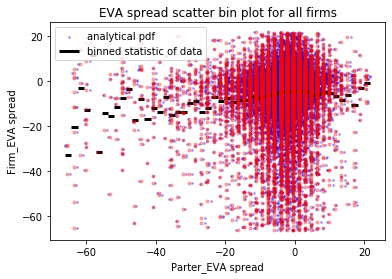

In [240]:
plt.scatter(dt.partner_EVAspread, dt.firm_EVAspread, color = 'blue', label='analytical pdf', alpha =0.3, s=3)
plt.hlines(dtbin_means, dtbin_edges[:-1], dtbin_edges[1:], colors='black', lw=3,
           label='binned statistic of data')
plt.plot((dtbinnumber-38.33666658)*dtbin_width, dt['firm_EVAspread'], 'r.', alpha=0.3, lw=1)
plt.legend(fontsize=10)
plt.title('EVA spread scatter bin plot for all firms')
plt.xlabel('Parter_EVA spread')
plt.ylabel('Firm_EVA spread')

In [241]:
firm_all=pd.DataFrame()
firm_all['firm_EVAspread']=dtbin_means
firm_all['partner_EVAspread'] =dtbin_centers
firm_all

,firm_EVAspread,partner_EVAspread
0,-32.836667,-65.185639
1,-20.122250,-63.432919
2,-3.035750,-61.680199
3,-12.743182,-59.927479
4,11.865000,-58.174759
5,-31.473000,-56.422039
6,-13.918000,-54.669319
7,-15.505800,-52.916600
8,-11.514833,-51.163880
9,-7.568333,-49.411160


In [242]:
# ols on Turkey: Combined customer & suppliers
# use firm & partner's EVAspread, 1% significance on EVAspread, positive coefficient, no significance relation duration, high R2
res_bin = sm.OLS(firm_all['firm_EVAspread'], firm_all[['partner_EVAspread']]).fit()
result_bin = sm.OLS(firm_all['firm_EVAspread'], sm.add_constant(firm_all[['partner_EVAspread']])).fit()
result_bin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         firm_EVAspread   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     13.88
Date:                Thu, 20 Aug 2020   Prob (F-statistic):           0.000512
Time:                        20:05:14   Log-Likelihood:                -161.02
No. Observations:                  50   AIC:                             326.0
Df Residuals:                      48   BIC:                             329.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.3914      1.164     -5.489      0.000      -8.733      -4.050
partner_EVAspread     0.1288      0.035      3.726      0.001       0.059       0.198
==============================================================================
Omnibus:                       20.974   Durbin-Watson:                   2.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.889
Skew:                           0.650   Prob(JB):                     6.16e-24
Kurtosis:                      10.044   Cond. No.                         44.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""